<a href="https://colab.research.google.com/github/temenino/github-slideshow/blob/master/Kopia_notatnika_FundsPickingAgrUni_1Q2022_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [452]:
import pandas as pd
import re
from bs4 import BeautifulSoup

import datetime
import numpy as np
import seaborn as sns
# from datetime import date
from scipy.stats import norm
import math

from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, PercentFormatter, FuncFormatter)
# import seaborn as sns
import requests

In [453]:
# !pip install xlrd==1.2.0
# !pip show xlrd

In [454]:
# start_date = pd.Timestamp(year=2021, month=12, day=31)
# end_date = pd.Timestamp(year=2020, month=12, day=31)
# period = [start_date - pd.Timedelta(days=i) for i in range(int(pd.Timedelta(start_date - end_date).days))]
# period

In [455]:
### lista do importu ze stooq.pl ###
# nazwą fufnudszu będzie nazwa z stooq'a, bez tickera w nawiasie, 
# który z będzie użyty do generacji url'a. 


stooq = [
"QUERCUS Parasolowy SFIO Subfundusz Agresywny (3441.N)",
"Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO (3360.N)",
"MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich (3187.N)",
"Credit Agricole FIO Subfundusz Akcyjny (2159.N)",
"Allianz FIO Subfundusz Selektywny (1422.N)",
"AGIO Subfundusz Akcji Plus (1001.N)",
# "BNP Paribas Akcji" "https://www.tfi.bnpparibas.pl/ajax/subfundPriceExport?id=14&ptid=1&lang=pl&format=csv&datefrom=2005-01-01&dateto=2022-02-21"
"UNIQA FIO Subfundusz Selektywny Akcji Polskich (1494.N)",
"Investor FIO Subfundusz Akcji Spółek Dywidendowych (2847.N)",
"Santander Prestiż SFIO Subfundusz Akcji Polskich (1692.N)",
"Rockbridge FIO Parasolowy Subfundusz Akcji (1626.N)",
"MetLife FIO Akcji (3165.N)",
"NN Parasol FIO Subfundusz Akcji A (2718.N)",
"BPS FIO Subfundusz BPS Akcji (1648.N)",
"UNIQA Akcji (4544.N)",
"Noble Funds FIO Subfundusz Akcji Polskich (3306.N)",
"Generali Akcje Wzrostu (3957.N)",
"ESA Parasol FIO Subfundusz Akcji (3151.N)",
"Santander Akcji Polskich A (1656.N)",
"BGŻ BNP Paribas FIO Dynamicznego Inwestowania (1612.N)",
# "Faranklin zdywersyfikowany akcji" - dostępne po logowaniu - "https://www.analizy.pl/private/FundFI/download/notow_mg.shtml?fundusz=TEM01"
"Superfund SFIO Portfelowy Akcyjny PLN (3935.N)",
"Pekao Subfundusz Pekao Akcji Polskich FIO (3361.N)",
"Aviva Investors FIO Subfundusz Polskich Akcji (2178.N)",
"Millennium FIO Subfundusz Akcji (3199.N)",
"Optimum FIO Subfundusz Akcji (3335.N)",
"Generali Korona Akcje (3959.N)",
"PKO Parasolowy FIO Subfundusz Akcji Plus (3396.N)",
"PZU FIO Akcji KRAKOWIAK (3423.N)",
"Skarbiec FIO Subfundusz Akcji Skarbiec Akcja (3872.N)",
"PKO Akcji Rynku Polskiego (1182.N)",
"Novo FIO Subfundusz Novo Akcji (3315.N)",
# "NN FIO Akcji 2"
"inPZU Akcje Polskie O (1621.N)",
"Beta ETF WIG20TR (ETFBW20TR.PL)",  # "https://stooq.pl/q/d/l/?s=etfbw20tr.pl&i=d" 
# "Superfund Akcji (superfund SFIO)", przekształcony w : Superfund Silver
# "AGIO SFIO Subfundusz Agresywny Spółek Wzrostowych (1004.N)",  # wycena co tydzień, wycofuję go ze słownika
"NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania (2719.N)"
# "PZU Akcji Polskich (PZU FIO Parasolowy)"  -  dostępno po logowaniu -  "https://www.analizy.pl/private/FundFI/download/notow_mg.shtml?fundusz=PZU71"
# "VIG C-QUADRAT Akcji" - "https://www.vigcq-tfi.pl/fundusze-otwarte,vig-c-quadrat-akcji/action/csv/priceTypeId/2.html"
]


In [456]:
rating_date = pd.Timestamp(year=2022, month=3, day=31)
# rating_date = pd.Timestamp(year=2021, month=12, day=30) # uwaga 2021-12-31 generuje błąd, daleko, chyba nie znajduje
start_date = pd.Timestamp(year=2022, month=4, day=23) # to jest data od której sie odmierzamy wstecz
end_date = pd.Timestamp(year=2018, month=1, day=2)   # to jest data początkowa do której sciągamy dane, wcześniejsza do start_date!
period = [start_date - pd.Timedelta(days=i) for i in range(int(pd.Timedelta(start_date - end_date).days))]


In [457]:
# np.arrange()
# rating_date = pd.Timestamp(year=2022, month=3, day=31)
rating_file = "rank-AgrUni-1Q2022.csv"
# rating_file = "rank-AgrUni-FY2021.csv"

In [458]:
###  ###

# dic_stooq = {}

def stooq_import(stooq, end_date, period):
    """
    funkcja importuje dane o funduszach ze strony stooq.pl
    argumenty : 
        stooq - lista nazw funduszy zgodna z nazwami ze stooq'a (zgodny musi być kod w nawiasie)
        end_date - najstarsza data poniżej, której dane sa odcinane
        period - lista dat dla dataframe'u, pełna, z weekendami, może być dłuższa niż do end_date, choć to nie ma sensu (redundancja się wdarła)
    wyjście :
        dataframe z wartościami jednostek funduszy
        kolumny to nazwy funduszy (tworzone na podstawie listy/argumentu)
        wiersze to daty
    
    url jest tworzony na podstawie kodu stooq'a (jest w nawiasie na liście)
    nazwy fundusze są tworzone na podstawie nazw z listy (bez kodu)
    daty (index) sa formaty pd.Timestamp
    wartości jednostek sa typu float
    """


    df = pd.DataFrame({"na" : ["na"]*len(period)}, index=period) # fake column to drop later, doesn't work on empty df
    df.index.name = "Data"

    for i,f in enumerate(stooq): # enumerate do wywalenia, zdaje się
        # generujemy kod/ticker wyciągając text w nawiasie
        fun_code = re.search(r"\(([\w.]*)\)", f)
        fun_code = fun_code.groups()[0]
        
        # wyciągamy nazwę funduszu odcinając nawiaz wraz z zawartością
        fun_name = re.search(r"(.*) \(", f)
        fun_name = fun_name.groups()[0]

        # składamy url'a
        url = f"https://stooq.pl/q/d/l/?s={fun_code}&i=d"

        # dic_stooq[fun_name] = url # tworzymy słownik: nazwa funduszu : url funduszu - tylko po co?

        # odczyt ze stooq'a
        # wszystko udało sie włożyć w linię z imoprtem 

        try:
            df_tmp = pd.read_csv(url, usecols=[0, 4], #index_col=0, 
                    parse_dates=['Data'], date_parser=lambda x: pd.Timestamp(x),
                    dtype={"Zamkniecie" : float})
        except:
            print(f"Wywaliło sie na : {f}. Sprawdź adres na stooq-u, bo pewnie zmienili.") 
            return

        df_tmp.rename(columns={"Zamkniecie": fun_name}, inplace=True)
        df_tmp = df_tmp[df_tmp["Data"] >= end_date].copy(deep=True) # owe copy/deep uchroni od SettingWithCopyWarning
        df_tmp.set_index("Data", inplace=True)

        # append new column 
        df = df.join(df_tmp, on="Data", how="left") # lsuffix='_caller', rsuffix='_other')

    # del fake column
    df.drop(labels="na", axis="columns", inplace=True)
    return df


df = stooq_import(stooq, end_date, period)
df

,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Optimum FIO Subfundusz Akcji,Generali Korona Akcje,PKO Parasolowy FIO Subfundusz Akcji Plus,PZU FIO Akcji KRAKOWIAK,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania
Data,,,,,,,,,,,,,,,,,,,,,
2022-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-22,239.27,13.66,7.53,161.47,113.45,163.96,154.50,637.04,1603.90,315.06,...,6.95,219.08,88.31,70.64,284.70,93.83,127.56,92.82,34.40,168.41
2022-04-21,242.85,13.94,7.71,165.10,116.30,168.11,157.40,652.52,1638.73,323.38,...,6.99,223.74,90.22,72.28,292.82,96.21,130.53,95.04,34.88,172.00
2022-04-20,243.40,13.93,7.75,165.68,116.83,168.26,158.48,658.86,1641.93,325.46,...,7.01,224.64,90.55,72.83,293.77,96.98,131.90,95.73,35.33,172.41
2022-04-19,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,6.99,225.29,91.05,73.38,295.21,97.80,130.52,96.47,35.57,172.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,194.57,11.64,6.77,144.30,103.83,155.60,136.30,452.18,1552.15,318.62,...,10.30,244.72,100.36,109.08,356.66,112.24,222.22,NaN,NaN,184.56


In [459]:
# [d for d in df_tmp.index if pd.Timestamp('2018-01-04') <= d <= pd.Timestamp('2018-01-15')]

In [460]:
#### impprt from stooq.pl ###
# Dobry pomysł z tym sortowaniem, ale Agio Kapitał ma wyceny co tydzień i rozwala pomysł
# po wywaleniu Agio Kapitał mozna sortować
# # stooq = sorted(stooq)

# start_date = pd.Timestamp(year=2021, month=12, day=31) # to jest data od której sie odmierzamy wstecz
# end_date = pd.Timestamp(year=2017, month=12, day=31)   # to jest data początkowa do której sciągamy dane, wcześniejsza do start_date!
# period = [start_date - pd.Timedelta(days=i) for i in range(int(pd.Timedelta(start_date - end_date).days))]

# dic_stooq = {}

# df = pd.DataFrame({"na" : ["na"]*len(period)}, index=period)
# df.index.name = "Data"


# for i,f in enumerate(stooq):
#     # print(f)
#     fun_code = re.search(r"\(([\w.]*)\)", f)
#     fun_code = fun_code.groups()[0]
#     # print(fun_code)

#     fun_name = re.search(r"(.*) \(", f)
#     fun_name = fun_name.groups()[0]
#     # print(fun_name)

#     url = f"https://stooq.pl/q/d/l/?s={fun_code}&i=d"
#     # print(url)

#     dic_stooq[fun_name] = url
#     df_tmp = pd.read_csv(url) #, delimiter=";")  # to generuje SettingWithCopyWarning:  , dla ESA Parasol FIO Subfundusz Akcji
#     # print()
#     try:
#         df_tmp['Data'] = df_tmp['Data'].apply(lambda x: pd.Timestamp(x))
#     except:
#         print("błąd przy impporcie funduszu : ", fun_name)
#     df_tmp = df_tmp[df_tmp["Data"] >= end_date].copy(deep=True) # owe copy/deep uchronio od SettingWithCopyWarning
#     df_tmp.drop(["Otwarcie", "Najwyzszy", "Najnizszy"], axis=1, inplace=True)
#     df_tmp.rename(columns={"Zamkniecie": fun_name}, inplace=True)
#     df_tmp.set_index("Data", inplace=True)

#     # print(len(df_tmp))

#     # tu jest coś nie ok jeszcze
#     df = df.join(df_tmp, on="Data", how="left") # lsuffix='_caller', rsuffix='_other')
#     # print(len(df))

# # dic_stooq
# # print(df_tmp.index[0])
# # print(type(df_tmp.index[0]))
# # df_tmp

# df.drop(labels="na", axis="columns", inplace=True)

# df

In [461]:
# dat = datetime.date.today() - datetime.timedelta(days=2)
# print(dat)
# # f"{dat.year}-{dat.month}-{dat.day}"

# print(str(start_date)[:10].replace("-", "."))
# print(f"{start_date.day}.{start_date.month}.{start_date.year}")
# print(f"{end_date.day}.{end_date.month}.{end_date.year}")

In [462]:
##### BNP Pariobas #####
# "https://www.tfi.bnpparibas.pl/ajax/subfundPriceExport?id=7&ptid=1&lang=pl&format=csv&datefrom=2016-03-28&dateto=2022-03-29"

bmp_dic = {"BNP Paribas Akcji" : 14}

# fun_name = "BNP Paribas Konserwatywnego Oszczędzania"

def bmp_tfi(bmp_dic):
    """
    BMP TFI 
    """

    end_day_txt = f"{start_date.year:02d}-{start_date.month:02d}-{start_date.day:02d}"
    begin_day_txt = f"{end_date.year:02d}-{end_date.month:02d}-{end_date.day:02d}"

    # url = "https://www.tfi.bnpparibas.pl/ajax/subfundPriceExport?id=7&ptid=1&lang=pl&format=csv&datefrom=2016-03-28&dateto=2022-03-29"


    first = True
    for k, v in bmp_dic.items():

        url = f"https://www.tfi.bnpparibas.pl/ajax/subfundPriceExport?id={v}&ptid=1&lang=pl&format=csv&datefrom={begin_day_txt}&dateto={end_day_txt}"

        bnp_tmp = pd.read_csv(url, delimiter=";", header=None, skiprows=[0, 1], names=["Data", k], index_col=0)
        bnp_tmp.index = bnp_tmp.index.map(lambda x: pd.Timestamp(x))
        bnp_tmp[k] = bnp_tmp[k].apply(lambda x: float(x))
        # bnp_tmp = bnp_tmp[::-1] # sortować, czy nie?

        if first:
            bnp_tfi_df = bnp_tmp
            first = False
        else:
            bnp_tfi_df = bnp_tfi_df.join(bnp_tmp, on="Data", how='left', rsuffix='_right')

    return bnp_tfi_df


# bnp_tfi_df = bmp_tfi(bmp_dic)
# bnp_tfi_df

### nie ma Baltic'a w OBL LT
df = df.join(bmp_tfi(bmp_dic), on="Data", how='left', rsuffix='_right')
df


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Generali Korona Akcje,PKO Parasolowy FIO Subfundusz Akcji Plus,PZU FIO Akcji KRAKOWIAK,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji
Data,,,,,,,,,,,,,,,,,,,,,
2022-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-22,239.27,13.66,7.53,161.47,113.45,163.96,154.50,637.04,1603.90,315.06,...,219.08,88.31,70.64,284.70,93.83,127.56,92.82,34.40,168.41,169.10
2022-04-21,242.85,13.94,7.71,165.10,116.30,168.11,157.40,652.52,1638.73,323.38,...,223.74,90.22,72.28,292.82,96.21,130.53,95.04,34.88,172.00,172.48
2022-04-20,243.40,13.93,7.75,165.68,116.83,168.26,158.48,658.86,1641.93,325.46,...,224.64,90.55,72.83,293.77,96.98,131.90,95.73,35.33,172.41,173.19
2022-04-19,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,225.29,91.05,73.38,295.21,97.80,130.52,96.47,35.57,172.98,173.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,194.57,11.64,6.77,144.30,103.83,155.60,136.30,452.18,1552.15,318.62,...,244.72,100.36,109.08,356.66,112.24,222.22,NaN,NaN,184.56,163.59


In [463]:
# soup.find("table").attrs
dat = datetime.date.today() - datetime.timedelta(days=2)
print(dat)

end_day_txt = f"{dat.day:02d}.{dat.month:02d}.{dat.year}"

print(end_day_txt)
d = end_day_txt
d = d.split(".")
d = datetime.date(year=int(d[2]), month=int(d[1]), day=int(d[0]))
print(d)

print(pd.Timestamp(end_day_txt)) # i to jest to!

pekao_dic = {"Pekao Konserwatywny": 1}
for fun in pekao_dic:
    print(fun)
    print(pekao_dic[fun])

2022-04-24
24.04.2022
2022-04-24
2022-04-24 00:00:00
Pekao Konserwatywny
1


In [464]:
##### Pekao tfi #####
# from bs4 import BeautifulSoup

# url = "https://pekaotfi.pl/pobierz/fund=1?type=csv"
# url = "https://stooq.pl/q/d/l/?s=3430.n&i=d"
# df_tmp = pd.read_csv(url) #, delimiter=";") # niestety lionk uruchamia js i to nie działa
# df_tmp

# begin_day_txt = "31.12.2017"
pekao_dic = {"Pekao Konserwatywny (Pekao FIO)" : 1, "Pekao Konserwatywny Plus (Pekao FIO)" : 92, 
             "Pekao Spokojna Inwestycja (Pekao Funduszy Globalnych SFIO)" : 63, "Pekao Obligacji Samorządowych" : 133}

def pekao_tfi(pekao_dic):
    """
    pekao TFI 
    """
    end_day_txt = f"{start_date.day:02d}.{start_date.month:02d}.{start_date.year:02d}"
    begin_day_txt = f"{end_date.day:02d}.{end_date.month:02d}.{end_date.year:02d}"

    first = True
    for k, v in pekao_dic.items():
    # for fun in pekao_dic:

        # url = "https://pekaotfi.pl/fundusze-inwestycyjne/wyceny-historyczne?fund=1&date-from=31.12.2017&date-to=01.04.2022"
        url = f"https://pekaotfi.pl/fundusze-inwestycyjne/wyceny-historyczne?fund={v}&date-from={begin_day_txt}&date-to={end_day_txt}"
        r = requests.get(url, allow_redirects=True)

        soup = BeautifulSoup(r.text, 'html.parser')

        # soup.find_all("td", {"class": "c-table__cell u-text-right"}) # tylko ceny
        tab = soup.find_all("td", {"class": ["c-table__cell", "u-text-right"]}) # daty i ceny co drugi

        x = [pd.Timestamp(t.text.strip()) for i,t in enumerate(tab) if i%2 == 0]
        y = [float(t.text.strip()) for i,t in enumerate(tab) if i%2 == 1]

        pekao_tmp = pd.DataFrame(y, index = x, columns = [k])
        pekao_tmp.index.name = "Data"
        # pekao_df = pekao_df[::-1] # nie potrzebne

        if first:
            pekao_tfi_df = pekao_tmp
            first = False
        else:
            pekao_tfi_df = pekao_tfi_df.join(pekao_tmp, on="Data", how='left', rsuffix='_right')

    return pekao_tfi_df

# pekao_tfi_df = pekao_tfi(pekao_dic)
# pekao_tfi_df

###########
# nie ma potrzeby w OBL LT
# df = df.join(pekao_tfi_df, on="Data", how='left', rsuffix='_right')
# df

In [465]:
##### Quercus TFI #####
# można też ściągnąc wszystkie fundusze Quercusa na raz - zamiast nr na końcu jest all
# nie ma atrybutu do filtrowania daty.

qrs_dic = {"Quercus Dłużny 1" : "https://quercustfi.pl/pl/download/historical_quotes/25877",
           "Quercus Dłużny 2" : "https://quercustfi.pl/pl/download/historical_quotes/25878"}

def qrs_tfi(qrs_dic):
    """
    QRS TFI 
    """

    first = True
    for k, v in qrs_dic.items():

        url = v
        qrs_tmp = pd.read_csv(url, delimiter=";", header=None, usecols=[1, 2], names=["Data", k], index_col=0)
        qrs_tmp.index = qrs_tmp.index.map(lambda x: pd.Timestamp(x))
        qrs_tmp[k] = qrs_tmp[k].apply(lambda x: float(x))

        if first:
            qrs_tfi_df = qrs_tmp
            first = False
        else:
            qrs_tfi_df = qrs_tfi_df.join(qrs_tmp, on="Data", how='left', rsuffix='_right')

    return qrs_tfi_df

# qrs_tfi(qrs_dic)

#######
# nie ma potrzeby w OBL LT
# df = df.join(qrs_tfi_df, on="Data", how='left', rsuffix='_right')
# df

In [466]:
##### PKO TFI #####
# można ściągnąc wszystkie notowania dla wszystkich funduszy PKO

# lista funduszy do importu
pko_funds = ["PKO Obligacji Samorządowych II"]

def pko_tfi(pko_funds):

    url = "https://www.pkotfi.pl/media_files/tfi/notowania_pl.csv"

    pko_funds = ["Data"] + pko_funds
    pko_tfi_df = pd.read_csv(url, delimiter=";", usecols=pko_funds, index_col=0)
    pko_tfi_df.index = pko_tfi_df.index.map(lambda x: pd.Timestamp(x))

    for fun in pko_funds[1:]:
        pko_tfi_df[fun] = pko_tfi_df[fun].apply(lambda x: float(str(x).replace(",", "."))) # jakiś dualizm, superpozycja występuje bo x.replace daje że x to float, a float(x) że x to str....

    return pko_tfi_df

# pko_tfi(pko_funds)

########
# nie ma potrzeby używać w OBL LT


In [467]:
### ING TFI ###
# zadziałał requests, pandas nie czyta csv, jakiś błąd związany z kodowaniem utf-8, o dziwo url wygenerowany działa
# możnaby jeszcze zakres dat uzmiiennić!!!
# initialDate=2019-03-29&finalDate=2022-03-31
# fundIds[]=1500279

# "https://www.ing.pl/_api/ds/ingrwd-lds/component_action?component.action=getQuotesValuesAsCsv&component.id=1402990699&component.site=1mDj0h6gvaXVjHcMEM1pWQ==&initialDate=2019-03-29&finalDate=2022-03-31&fundIds[]=1500279"
# 1500250

url = "https://www.ing.pl/_api/ds/ingrwd-lds/component_action?component.action=getQuotesValuesAsCsv&component.id=1402990699&component.site=1mDj0h6gvaXVjHcMEM1pWQ==&initialDate=2019-03-29&finalDate=2022-03-31&fundIds[]=1500279"

ing_dic = {"ING Pakiet Ostrożny" : "1500279"} # ING ma tam też dane o innych TFI np: , "Generali Korona Akcje" : "1500250"}


def ing_tfi(ing_dic):
    """
    ING TFI
    """

    first = True

    for k, v in ing_dic.items():

        url = f"https://www.ing.pl/_api/ds/ingrwd-lds/component_action?component.action=getQuotesValuesAsCsv&component.id=1402990699&component.site=1mDj0h6gvaXVjHcMEM1pWQ==&initialDate=2019-03-29&finalDate=2022-03-31&fundIds[]={v}"

        r = requests.get(url, allow_redirects=True)
        txt = r.text
        txt = txt.split("\n")
        txt = [t.split(";") for t in txt]

        ing_dic = [(pd.Timestamp(t[0]), float(t[1].replace(',', '.'))) for t in txt[1:-1]]
        ing_tmp = pd.DataFrame.from_records(ing_dic, columns=["Data", k], index="Data")

        if first:
            ing_tfi_df = ing_tmp
            first = False
        else:
            ing_tfi_df = ing_tfi_df.join(ing_tmp, on="Data", how='left', rsuffix='_right')

    return ing_tfi_df

# print(ing_tfi(ing_dic))

# nie używany w OBL LT
# df = df.join(ing_tfi(ing_dic), on="Data", how='left', rsuffix='_right')
# df


In [468]:
##### NN tfi #####

# url = f"https://www.nntfi.pl/fundusze-inwestycyjne/fundusze-akcji/nn-indeks-obligacji?action=quotes.getQuotesCsv&unitCategoryIds=1&fundIds=1500090&startDate=2020-06-22&endDate=2022-04-14"
# url = f"https://www.nntfi.pl/fundusze-inwestycyjne/fundusze-mieszane/nn-zrownowazony?action=quotes.getQuotesCsv&unitCategoryIds=1&fundIds=2&startDate=2017-04-13&endDate=2022-04-14"


nn_dic = {"NN Indeks Obligacji" : ["nn-indeks-obligacji", "fundusze-akcji", 1500090]}

def nn_tfi(nn_dic):
    """
    NN TFI 
    """
    end_day_txt = f"{start_date.year:02d}-{start_date.month:02d}-{start_date.day:02d}"
    # end_day_txt = str(start_date)[:10]
    begin_day_txt = f"{end_date.year:02d}-{end_date.month:02d}-{end_date.day:02d}"
    # begin_day_txt = str(end_date)[:10]

    first = True
    for k, v in nn_dic.items():

        url = f"https://www.nntfi.pl/fundusze-inwestycyjne/{v[1]}/{v[0]}?action=quotes.getQuotesCsv&unitCategoryIds=1&fundIds={v[2]}&startDate={begin_day_txt}&endDate={end_day_txt}"
        # url = f"https://www.nntfi.pl/fundusze-inwestycyjne/fundusze-akcji/nn-indeks-obligacji?action=quotes.getQuotesCsv&unitCategoryIds=1&fundIds=1500090&startDate=2020-06-22&endDate=2022-04-14"
    
        nn_tmp = pd.read_csv(url, delimiter=",", usecols=[0, 1], header=0, index_col=0, names=["Data", k], encoding="cp852") # encoding="cp852" - lekarstwo na "ś" !!!!
        nn_tmp.index = nn_tmp.index.map(lambda x: pd.Timestamp(x))
        nn_tmp[k] = nn_tmp[k].apply(lambda x: float(x))

        if first:
            nn_tfi_df = nn_tmp
            first = False
        else:
            nn_tfi_df = nn_tfi_df.join(nn_tmp, on="Data", how='left', rsuffix='_right')    

    return nn_tfi_df

print(nn_tfi(nn_dic))


###########
# 
# df = df.join(nn_tfi(nn_dic), on="Data", how='left', rsuffix='_right')
# df

            NN Indeks Obligacji
Data                           
2020-06-22               100.00
2020-06-23               100.00
2020-06-24               100.00
2020-06-25               100.00
2020-06-26               100.00
...                         ...
2022-04-14                83.64
2022-04-19                82.76
2022-04-20                83.31
2022-04-21                83.14
2022-04-22                82.81

[463 rows x 1 columns]


In [469]:
##### Agro tfi #####
### to będzie webscrapping ###
# from bs4 import BeautifulSoup

# "https://www.tfiagro.pl/fio/agro-obligacji#valuation"
# "https://www.tfiagro.pl/fio/agro-rynku-pienieznego#valuation"


agro_dic_all = {"Agro Obligacji" : "agro-obligacji", "Agro Rynku Pieniężnego" : "agro-rynku-pienieznego"}

agro_dic = {"Agro Obligacji" : "agro-obligacji", "Agro Rynku Pieniężnego" : "agro-rynku-pienieznego"}

def agro_tfi(agro_dic):
    """

    """
    agro_tfi_df = pd.DataFrame()
    first = True

    for fun in agro_dic:
        url = f"https://www.tfiagro.pl/fio/{agro_dic[fun]}#valuation"

        r = requests.get(url, allow_redirects=True)
        soup = BeautifulSoup(r.text, 'html.parser')

        tab = soup.find("tbody")
        tab = tab.find_all('tr', attrs={"data-category" : "A"})

        agro_tmp = [(pd.Timestamp(t.find_all('td')[0].text), float(t.find_all('td')[1].text.replace(' zł', '').replace(',', '.'))) for t in tab]
        agro_tmp = pd.DataFrame.from_records(agro_tmp, columns=["Data", fun], index="Data")
        
        if first:
            agro_tfi_df = agro_tmp
            first = False
        else:
            agro_tfi_df = agro_tfi_df.join(agro_tmp, on="Data", how='left', rsuffix='_right')

    return agro_tfi_df

# agro_tfi(agro_dic)

# ni3 używany w OBP LT
### joion with rest of funds ###
# nie używamy w OBL LT
# df = df.join(agro_tfi, on="Data", how='left', rsuffix='_right')
# df


In [470]:
### TFI Energia ###
# prosta csv-ka
# trzeba sformatować header

energia_dic_all = {"Energia Konserwatywny" : "https://tfienergia.pl/fundvaluation/P%C5%81YNN/exportsubfund.csv",
                "Energia Ochrony Absolutnej Stopy Zwrotu" : "https://tfienergia.pl/fundvaluation/OASZ/exportsubfund.csv",
                "Energia Agresywny Absolutnej Stopy Zwrotu" : "https://tfienergia.pl/fundvaluation/AASZ/exportsubfund.csv"}

# lista funduszy do importu
energia_dic = {"Energia Konserwatywny" : "https://tfienergia.pl/fundvaluation/P%C5%81YNN/exportsubfund.csv"}


def energia_tfi(energia_dic):

    """
    TFI Energia
    """

    first = True
    for k, v in energia_dic.items():

        url = v
        ene_tmp = pd.read_csv(url, delimiter=";", header=None, usecols=[0, 1], names=["Data", k], index_col=0, skiprows=3)
        ene_tmp.index = ene_tmp.index.map(lambda x: pd.Timestamp(x))
        ene_tmp[k] = ene_tmp[k].apply(lambda x: float(x.replace(',', '.')))

        if first:
            ene_tfi_df = ene_tmp
            first = False
        else:
            ene_tfi_df = ene_tfi_df.join(ene_tmp, on="Data", how='left', rsuffix='_right')

    return ene_tfi_df

print(energia_tfi(energia_dic))

### joion with rest of funds ###
# df = df.join(energia_tfi(energia_dic), on="Data", how='left', rsuffix='_right')
# df


            Energia Konserwatywny
Data                             
2022-04-22                 107.65
2022-04-21                 107.90
2022-04-20                 107.52
2022-04-19                 107.91
2022-04-14                 108.04
...                           ...
2017-12-12                 100.10
2017-12-11                 100.09
2017-12-08                 100.08
2017-12-07                 100.08
2017-12-06                 100.07

[1091 rows x 1 columns]


In [471]:
##### VIG C-Quadrat tfi  #####
### pandas csv ###

vigc_dic_all = {"VIG C-QUADRAT Konserwatywny" : "vig-c-quadrat-konserwatywny", "VIG C-Quadrat Obligacji" : "vig-c-quadrat-obligacji",
                "VIG C-QUADRAT Obligacji Korporacyjnych" : "vig-c-quadrat-obligacji-korporacyjnych", "VIG C-QUADRAT Akcji" : "vig-c-quadrat-akcji",
                "VIG C-QUADRAT Global Growth Trends" : "vig-c-quadrat-global-growth-trends", 
                "VIG C-QUADRAT ARTS Total Return Bond" : "c-quadrat-arts-total-return-bond",
                "VIG C-QUADRAT GreenStars" : "c-quadrat-greenstars-esg"}

vigc_dic = {"VIG C-QUADRAT Akcji" : "vig-c-quadrat-akcji"} # może być więcej funduszy


def vig_tfi(vigc_dic):
    """
    Function import date for VIG CQuadrat TFI from their site.
    Arguments : dictionary with Funds names : url fragment.
    Result : DataFrame with unit value for all funds from dictionary. Data are not filered.
    """

    vig_tfi_df = pd.DataFrame()
    first = True

    for k, f in vigc_dic.items():
        url = f"https://www.vigcq-tfi.pl/fundusze-otwarte,{f}/action/csv/priceTypeId/2.html"
        vig_tfi_tmp = pd.read_csv(url, delimiter=";", usecols=[0, 2], index_col=0)
        vig_tfi_tmp.index = vig_tfi_tmp.index.map(lambda x: pd.Timestamp(x))
        vig_tfi_tmp.index.names = ["Data"]
        vig_tfi_tmp.rename(columns={'Wycena': k}, inplace=True)
        
        if first:
            vig_tfi_df = vig_tfi_tmp
            first = False
        else:
            vig_tfi_df = vig_tfi_df.join(vig_tfi_tmp, on="Data", how='left', rsuffix='_right')

    return vig_tfi_df


vig_tfi(vigc_dic_all)

### joion with rest of funds ###
df = df.join(vig_tfi(vigc_dic), on="Data", how='left', rsuffix='_right')
df


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,PKO Parasolowy FIO Subfundusz Akcji Plus,PZU FIO Akcji KRAKOWIAK,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji
Data,,,,,,,,,,,,,,,,,,,,,
2022-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-22,239.27,13.66,7.53,161.47,113.45,163.96,154.50,637.04,1603.90,315.06,...,88.31,70.64,284.70,93.83,127.56,92.82,34.40,168.41,169.10,87.04
2022-04-21,242.85,13.94,7.71,165.10,116.30,168.11,157.40,652.52,1638.73,323.38,...,90.22,72.28,292.82,96.21,130.53,95.04,34.88,172.00,172.48,89.03
2022-04-20,243.40,13.93,7.75,165.68,116.83,168.26,158.48,658.86,1641.93,325.46,...,90.55,72.83,293.77,96.98,131.90,95.73,35.33,172.41,173.19,89.18
2022-04-19,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,91.05,73.38,295.21,97.80,130.52,96.47,35.57,172.98,173.74,89.48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,194.57,11.64,6.77,144.30,103.83,155.60,136.30,452.18,1552.15,318.62,...,100.36,109.08,356.66,112.24,222.22,NaN,NaN,184.56,163.59,NaN


In [472]:
#### Esaliens TFI ####
# podają csv xls i xlsx, tu: https://www.esaliens.pl/pl/notowania-funduszy/wyceny-funduszy/archiwum-wycen
# https://www.esaliens.pl/funds/exportdata/LMOBLIG/csv  # ESALIENS Obligacji 
# https://www.esaliens.pl/funds/exportdata/LMPIEN/csv  # ESALIENS Konserwatywny
# https://www.esaliens.pl/funds/exportdata/LMAKCJI/csv  # ESALIENS Akcji 
# https://www.esaliens.pl/funds/exportdata/LMSELECT/csv  # ESALIENS Małych i Średnich Spółek

url = "https://www.esaliens.pl/funds/exportdata/LMOBLIG/csv"

# wszystko udało sie włożyć w linię z imoprtem - dobre!!!
esa_tfi_tmp = pd.read_csv(url, delimiter=";", skiprows=2, usecols=[1, 2], index_col=0, names=["Data", "ESALIENS Obligacji"],
                          parse_dates=['Data'], date_parser=lambda x: pd.Timestamp(x))  #, header=None, dtype={"ESALIENS Obligacji" : float})

print(esa_tfi_tmp)

# niedorobiony bo nie jest tu potrzebny

            ESALIENS Obligacji
Data                          
2022-04-22              260.75
2022-04-21              261.59
2022-04-20              261.93
2022-04-19              260.05
2022-04-14              262.86
...                        ...
1999-01-08              100.17
1999-01-07              100.15
1999-01-06              100.12
1999-01-05              100.05
1999-01-04              100.00

[5857 rows x 1 columns]


In [473]:
# ### additional import from Analizy Online###
fpath = "/content/drive/My Drive/FundPicking/FY2021/"

patch = {"PZU Akcji Polskich (PZU FIO Parasolowy)" : "(2022-04-22)Notowania PZU Akcji Polskich (PZU FIO Parasolowy).xls",
         "Faranklin zdywersyfikowany akcji" : "(2022-04-21)Notowania Franklin Zdywersyfikowany Akcji B (FT FIO).xls"
         }

addons = pd.DataFrame()
lst = []

for k,v in patch.items():

    if addons.empty:
        addons = pd.read_excel(fpath + v, skiprows=2, index_col=0, usecols=[0,1], names=["date", k])
    else:
        tmp = pd.DataFrame()
        tmp = pd.read_excel(fpath + v, skiprows=2, index_col=0, usecols=[0,1], names=["date", k])
        lst.append(tmp)

addons = addons.join(lst, how="outer")
# addons.sort_index(axis="index", ascending=False, inplace=True)
# addons = addons[::-1]

# addons = addons[addons.index < "2022-03-31"]
addons = addons[addons.index > "2018-01-01"]
addons.index.name = "Data"
# print(type(addons.index[0]))
# print(type(df.index[0]))


# df = df[df.index <= "2022-02-28"]
# df.to_csv(fpath + "AgrUni.csv")

#### dodaj kolumny do df ####
df = df.join(addons, on="Data", how='left', rsuffix='_right')
df

,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
Data,,,,,,,,,,,,,,,,,,,,,
2022-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-22,239.27,13.66,7.53,161.47,113.45,163.96,154.50,637.04,1603.90,315.06,...,284.70,93.83,127.56,92.82,34.40,168.41,169.10,87.04,59.59,NaN
2022-04-21,242.85,13.94,7.71,165.10,116.30,168.11,157.40,652.52,1638.73,323.38,...,292.82,96.21,130.53,95.04,34.88,172.00,172.48,89.03,60.83,116.64
2022-04-20,243.40,13.93,7.75,165.68,116.83,168.26,158.48,658.86,1641.93,325.46,...,293.77,96.98,131.90,95.73,35.33,172.41,173.19,89.18,61.23,116.91
2022-04-19,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,295.21,97.80,130.52,96.47,35.57,172.98,173.74,89.48,61.67,117.37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-05,194.57,11.64,6.77,144.30,103.83,155.60,136.30,452.18,1552.15,318.62,...,356.66,112.24,222.22,NaN,NaN,184.56,163.59,NaN,NaN,125.38


In [474]:
!pip install xlrd==1.2.0
!pip show xlrd

Name: xlrd
Version: 1.2.0
Summary: Library for developers to extract data from Microsoft Excel (tm) spreadsheet files
Home-page: http://www.python-excel.org/
Author: John Machin
Author-email: sjmachin@lexicon.net
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: 
Required-by: 


In [475]:
# ### additional import from Analizy Online###
# ### Nie korzystamy tu z analiz online - martwy kod bo może będzie potrzebny ###
# fpath = "/content/drive/My Drive/FundPicking/FY2021/"

# patch = {"Aviva Investors SFIO Stabilnego Dochodu" : "(2022-03-28)Notowania Aviva Investors SFIO Stabilnego Dochodu.xls"}


# addons = pd.DataFrame()
# lst = []

# for k,v in patch.items():

#     if addons.empty:
#         addons = pd.read_excel(fpath + v, skiprows=2, index_col=0, usecols=[0,1], names=["date", k])
#     else:
#         tmp = pd.DataFrame()
#         tmp = pd.read_excel(fpath + v, skiprows=2, index_col=0, usecols=[0,1], names=["date", k])
#         lst.append(tmp)

# addons = addons.join(lst, how="outer")
# # addons.sort_index(axis="index", ascending=False, inplace=True)
# # addons = addons[::-1]

# addons = addons[addons.index < "2022-03-20"]
# addons = addons[addons.index > "2018-01-01"]
# addons.index.name = "Data"
# # print(type(addons.index[0]))
# # print(type(df.index[0]))

# # addons

# # df = df.join(addons, on="Data", how='left', rsuffix='_right')

# # df = df[df.index <= "2022-02-28"]
# # df.to_csv(fpath + "OblST.csv")

# # df


In [476]:
### wypełniamy dziury dla dodanych funduszy, weekendy ###
funds = df[::-1][:-1]
funds.fillna(method="backfill", inplace=True, limit=5)
# print(type(funds.index[0]))
# funds = df
# print(type(df.iloc[0, -1]), df.iloc[0, -1], pd.isna(df.iloc[0, -1]))
# print()
# print(df["Esaliens Małych i Srednich Spółek (Esaliens Parasol FIO)"].mean())
funds

,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
Data,,,,,,,,,,,,,,,,,,,,,
2018-01-03,191.94,11.43,6.63,142.25,102.05,152.38,134.11,445.86,1530.17,312.27,...,352.33,111.40,216.41,NaN,NaN,182.10,160.61,NaN,NaN,123.56
2018-01-04,194.04,11.63,6.75,144.31,103.87,155.13,136.21,449.86,1556.09,318.64,...,357.17,111.89,221.18,NaN,NaN,183.78,163.44,NaN,NaN,124.42
2018-01-05,194.57,11.64,6.77,144.30,103.83,155.60,136.30,452.18,1552.15,318.62,...,356.66,112.24,222.22,NaN,NaN,184.56,163.59,NaN,NaN,125.38
2018-01-06,195.64,11.67,6.80,145.00,104.49,156.05,136.86,456.21,1558.92,320.85,...,358.29,112.00,222.90,NaN,NaN,185.31,164.48,NaN,NaN,127.74
2018-01-07,195.64,11.67,6.80,145.00,104.49,156.05,136.86,456.21,1558.92,320.85,...,358.29,112.00,222.90,NaN,NaN,185.31,164.48,NaN,NaN,127.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-18,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,295.21,97.80,130.52,96.47,35.57,172.98,173.74,89.48,61.67,117.37
2022-04-19,244.33,13.97,7.82,166.31,117.28,168.00,159.43,660.22,1648.13,328.34,...,295.21,97.80,130.52,96.47,35.57,172.98,173.74,89.48,61.67,117.37
2022-04-20,243.40,13.93,7.75,165.68,116.83,168.26,158.48,658.86,1641.93,325.46,...,293.77,96.98,131.90,95.73,35.33,172.41,173.19,89.18,61.23,116.91


In [477]:
for f in funds.columns:
    print(f, " : ", funds[f].isna().sum())


QUERCUS Parasolowy SFIO Subfundusz Agresywny  :  0
Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO  :  0
MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich  :  0
Credit Agricole FIO Subfundusz Akcyjny  :  0
Allianz FIO Subfundusz Selektywny  :  0
AGIO Subfundusz Akcji Plus  :  0
UNIQA FIO Subfundusz Selektywny Akcji Polskich  :  23
Investor FIO Subfundusz Akcji Spółek Dywidendowych  :  0
Santander Prestiż SFIO Subfundusz Akcji Polskich  :  0
Rockbridge FIO Parasolowy Subfundusz Akcji  :  0
MetLife FIO Akcji  :  0
NN Parasol FIO Subfundusz Akcji A  :  0
BPS FIO Subfundusz BPS Akcji  :  0
UNIQA Akcji  :  23
Noble Funds FIO Subfundusz Akcji Polskich  :  0
Generali Akcje Wzrostu  :  0
ESA Parasol FIO Subfundusz Akcji  :  0
Santander Akcji Polskich A  :  0
BGŻ BNP Paribas FIO Dynamicznego Inwestowania  :  0
Superfund SFIO Portfelowy Akcyjny PLN  :  84
Pekao Subfundusz Pekao Akcji Polskich FIO  :  15
Aviva Investors FIO Subfundusz Polskich Akcji  :  0
Millennium FIO Subfundusz Akcji  

In [478]:
funds.columns

Index(['QUERCUS Parasolowy SFIO Subfundusz Agresywny',
       'Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO',
       'MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich',
       'Credit Agricole FIO Subfundusz Akcyjny',
       'Allianz FIO Subfundusz Selektywny', 'AGIO Subfundusz Akcji Plus',
       'UNIQA FIO Subfundusz Selektywny Akcji Polskich',
       'Investor FIO Subfundusz Akcji Spółek Dywidendowych',
       'Santander Prestiż SFIO Subfundusz Akcji Polskich',
       'Rockbridge FIO Parasolowy Subfundusz Akcji', 'MetLife FIO Akcji',
       'NN Parasol FIO Subfundusz Akcji A', 'BPS FIO Subfundusz BPS Akcji',
       'UNIQA Akcji', 'Noble Funds FIO Subfundusz Akcji Polskich',
       'Generali Akcje Wzrostu', 'ESA Parasol FIO Subfundusz Akcji',
       'Santander Akcji Polskich A',
       'BGŻ BNP Paribas FIO Dynamicznego Inwestowania',
       'Superfund SFIO Portfelowy Akcyjny PLN',
       'Pekao Subfundusz Pekao Akcji Polskich FIO',
       'Aviva Investors FIO Subfundusz P

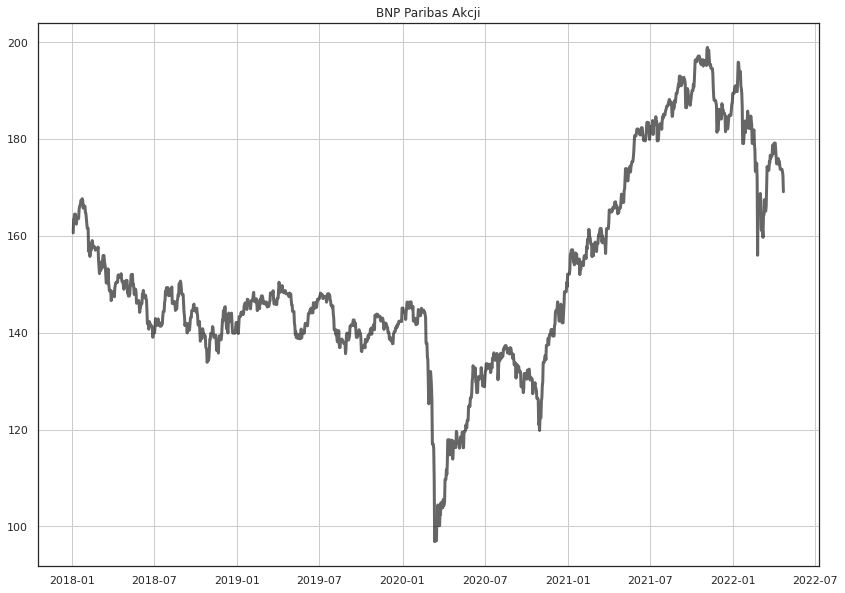

In [479]:
### funds chart ###

# funds = bench_rates
# fun = "BGŻ BNP Paribas FIO Dynamicznego Inwestowania"

fun = 'BNP Paribas Akcji' #@param ['QUERCUS Parasolowy SFIO Subfundusz Agresywny', 'Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO', 'MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich', 'Credit Agricole FIO Subfundusz Akcyjny', 'Allianz FIO Subfundusz Selektywny', 'AGIO Subfundusz Akcji Plus', 'UNIQA FIO Subfundusz Selektywny Akcji Polskich', 'Investor FIO Subfundusz Akcji Spółek Dywidendowych', 'Santander Prestiż SFIO Subfundusz Akcji Polskich', 'Rockbridge FIO Parasolowy Subfundusz Akcji', 'MetLife FIO Akcji', 'NN Parasol FIO Subfundusz Akcji A', 'BPS FIO Subfundusz BPS Akcji', 'UNIQA Akcji', 'Noble Funds FIO Subfundusz Akcji Polskich', 'Generali Akcje Wzrostu', 'ESA Parasol FIO Subfundusz Akcji', 'Santander Akcji Polskich A', 'BGŻ BNP Paribas FIO Dynamicznego Inwestowania', 'Superfund SFIO Portfelowy Akcyjny PLN', 'Pekao Subfundusz Pekao Akcji Polskich FIO', 'Aviva Investors FIO Subfundusz Polskich Akcji', 'Millennium FIO Subfundusz Akcji', 'Optimum FIO Subfundusz Akcji', 'Generali Korona Akcje', 'PKO Parasolowy FIO Subfundusz Akcji Plus', 'PZU FIO Akcji KRAKOWIAK', 'Skarbiec FIO Subfundusz Akcji Skarbiec Akcja', 'PKO Akcji Rynku Polskiego', 'Novo FIO Subfundusz Novo Akcji', 'inPZU Akcje Polskie O', 'Beta ETF WIG20TR', 'Wolumen', 'NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania', 'BNP Paribas Akcji', 'VIG C-QUADRAT Akcji']

x = funds.index
y = funds.loc[:, fun]

plt.figure(figsize=(14, 10)) # , dpi=80)
plt.plot(funds.index, funds.loc[:, fun], color="#000000", alpha=0.6, linewidth=3)
# plt.plot(bench_rates.loc[p], bins=baskets, color="seagreen", alpha=0.6, edgecolor='#008850', linewidth=1.2)
plt.grid(visible=True, which='major', axis='both')
plt.title(fun)

plt.show()

In [480]:
start_date

Timestamp('2022-04-23 00:00:00')

In [481]:
# bechmarki : WIG	SWIG80	MWIG40	WIBOR
benchmarks_url = {
"WIG" : "https://stooq.pl/q/d/l/?s=wig&i=d",
"SWIG80" : "https://stooq.pl/q/d/l/?s=SWIG80&i=d",
"MWIG40" : "https://stooq.pl/q/d/l/?s=MWIG40&i=d",
"TBSP" : "https://stooq.pl/q/d/l/?s=^tbsp&i=d"}
# "WIBOR" : "https://stooq.pl/q/?s=plopln1m"

wibor1m_url = "https://stooq.pl/q/d/l/?s=plopln1m&i=d"

def read_benchmarks(bench_name, url):
    df_tmp = pd.read_csv(url) #, delimiter=";")  # to generuje SettingWithCopyWarning:  , dla ESA Parasol FIO Subfundusz Akcji
    df_tmp['Data'] = df_tmp['Data'].apply(lambda x: pd.Timestamp(x))
    df_tmp = df_tmp[df_tmp["Data"] >= end_date] # "2018-01-01"]
    df_tmp.drop(["Otwarcie", "Najwyzszy", "Najnizszy", "Wolumen"], axis=1, inplace=True)
    df_tmp.rename(columns={"Zamkniecie": bench_name}, inplace=True)
    df_tmp.set_index("Data", inplace=True)
    return df_tmp

bench = pd.DataFrame()
first = True
for b, u in benchmarks_url.items():
    bench_name = b
    url = u

    df_tmp = read_benchmarks(bench_name, url)

    if first:
        bench.index = df_tmp.index
        first = False

    bench = bench.join(df_tmp, on="Data")

bench = bench[bench.index >= end_date]
bench = bench[bench.index <= start_date]  

# print(bench)


### benchmark rates ###
 
# bench_rates = bench[::-1].pct_change(1)[::-1]
bench_rates = bench.pct_change(1)
bench_rates['0,6WIG+0,4sWIG'] = 0.6*bench_rates['WIG'] + 0.4*bench_rates['SWIG80']


### read WIBOR ###
df_tmp = pd.read_csv(wibor1m_url) 
df_tmp['Data'] = df_tmp['Data'].apply(lambda x: pd.Timestamp(x))
df_tmp = df_tmp[df_tmp["Data"] >= end_date] # "2018-01-01"]
df_tmp.drop(["Otwarcie", "Najwyzszy", "Najnizszy"], axis=1, inplace=True)
df_tmp.rename(columns={"Zamkniecie": "WIBOR"}, inplace=True)
df_tmp.set_index("Data", inplace=True)
# print(df_tmp)

wibor = df_tmp

wibor_rates = wibor['WIBOR'].apply(lambda x: x/3650)

print(wibor_rates)
# print(wibor1m)

bench_rates = bench_rates.join(wibor_rates, on="Data")
print(bench_rates)
# print(type(bench_rates.index[0]))


Data
2018-01-02    0.000452
2018-01-03    0.000452
2018-01-04    0.000452
2018-01-05    0.000452
2018-01-08    0.000452
                ...   
2022-04-19    0.001321
2022-04-20    0.001334
2022-04-21    0.001342
2022-04-22    0.001351
2022-04-25    0.001367
Name: WIBOR, Length: 1088, dtype: float64
                 WIG    SWIG80    MWIG40      TBSP  0,6WIG+0,4sWIG     WIBOR
Data                                                                        
2018-01-03       NaN       NaN       NaN       NaN             NaN  0.000452
2018-01-04  0.021936  0.006125  0.010624  0.001767        0.015612  0.000452
2018-01-05  0.000251  0.009419  0.002376  0.001662        0.003918  0.000452
2018-01-08  0.007527  0.006226  0.007604 -0.000481        0.007007  0.000452
2018-01-09 -0.006103  0.001108 -0.003553 -0.001887       -0.003218  0.000452
...              ...       ...       ...       ...             ...       ...
2022-04-14 -0.004331 -0.000120 -0.004465 -0.002636       -0.002647  0.001299
2022-04

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [482]:
### cumulative rates ###
bench_cum_rates = bench_rates.add(1)
bench_cum_rates.iloc[0, :] = 1
# bench_cum_rates.loc["2018-01-03", :] = 1
# bench_cum_rates['Data'] = bench_cum_rates.index.apply(lambda x: pd.Timestamp(x))
# bench_cum_rates.Index.astype(pd.Timestamp, copy=True)

for b in bench_cum_rates.columns:
    cum = 1
    for d in bench_cum_rates.index:
        cum *= bench_cum_rates.loc[d, b]
        bench_cum_rates.loc[d, b] = cum

print(type(bench_cum_rates.index[0]))
bench_cum_rates

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


,WIG,SWIG80,MWIG40,TBSP,"0,6WIG+0,4sWIG",WIBOR
Data,,,,,,
2018-01-03,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2018-01-04,1.021936,1.006125,1.010624,1.001767,1.015612,1.000452
2018-01-05,1.022192,1.015602,1.013026,1.003433,1.019591,1.000904
2018-01-08,1.029887,1.021925,1.020729,1.002950,1.026735,1.001357
2018-01-09,1.023602,1.023057,1.017102,1.001057,1.023430,1.001809
...,...,...,...,...,...,...
2022-04-14,0.997867,1.329904,0.958823,0.965372,1.129214,1.434192
2022-04-19,0.989114,1.323958,0.957782,0.954460,1.121251,1.436086
2022-04-20,0.982530,1.328480,0.953291,0.960934,1.118305,1.438002


In [483]:
start_date

Timestamp('2022-04-23 00:00:00')

In [484]:
#####################
### dates madness ###
# start_date = pd.Timestamp(year=2021, month=12, day=31) # to jest data od której sie odmierzamy wstecz
# start_date = max(x for x in funds.index if x <= start_date) # no bo może nie być 
periods = ["1M", "3M", "6M", "1Y", "3Y"]


### convert period to dates ###
def period_to_date(start, period):
    date_dic = {'1M':[0, -1, 0], '3M':[0, -3, 0], '6M':[0, -6, 0], '1Y':[-1, 0, 0], '3Y':[-3, 0, 0]}
    # delta = datetime.timedelta(years=date_dic[period][0], months=date_dic[period][1], days=0) # no years and months...
    y = start.year + date_dic[period][0]
    if start.month <= -date_dic[period][1]:
        y = start.year - 1
        m = start.month + 12 + date_dic[period][1]
    else:
        m = start.month + date_dic[period][1]
    d = start.day + date_dic[period][2]
    # print(y, m, d)
    # return datetime.date(year=y, month=m, day=d)
    try:
        res = datetime.date(year=y, month=m, day=d)
    except:
        res = datetime.date(year=y, month=m+1, day=1) - datetime.timedelta(days=1)
    return res
    # return pd.Timestamp(year=res.year, month=res.month, day=res.day)



### find exact dates from dataframe ###
def find_date(dat, funds):
    ### maybe I should use datetime from the beginning ###
    ### but I leave it for now as it is ###
    dat = pd.Timestamp(year=dat.year, month=dat.month, day=dat.day)
    # print("from date : ", funds.index)
    # print(dat, dat in funds.index)
    filt = funds.index >= dat
    return funds[filt].index[0] # Zmiana!!! tego chyba nie trzeba robić na całej df tylko na indexie
    # return funds[filt].index[-1]


def rate_of_return(start_date, period, fund_name, funds):
    start_date = find_date(start_date, funds) # 31 grudnia nie ma notowań 
    dat = period_to_date(start_date, period)
    dat = find_date(dat, funds)
    start_date = pd.Timestamp(year=start_date.year, month=start_date.month, day=start_date.day)   
    return (funds.loc[start_date, fund_name] / funds.loc[dat, fund_name]) - 1


# fund_name = "QUERCUS Parasolowy SFIO Subfundusz Obligacji Skarbowych"
# period='1M'
# dat = period_to_date(start_date, period)
# print(dat)
# print('+++')
# # find_date(dat, funds)
# print(start_date)
# # display(funds)

# dat = find_date(pd.Timestamp("2021-11-30"), funds)
# x1 = funds.loc[start_date, fund_name]
# x2 = funds.loc[dat, fund_name]
# print("=>", x1, x2, x1/x2 - 1)


# print()
# print("================")
# # start_date = pd.Timestamp(year=2021, month=12, day=31)
# # start_date = find_date(start_date, funds)
# # print(start_date)
# d1 = period_to_date(start_date, period)
# d1 = pd.Timestamp(year=d1.year, month=d1.month, day=d1.day)
# print(d1)

# e = funds.loc[start_date, fund_name]
# d = funds.loc[d1, fund_name]
# print(e, d, e/d-1)
# print(rate_of_return(start_date, period, fund_name, funds))

# def ror(start_date, period, fund_name, funds):
#     d1 = period_to_date(start_date, period)
#     d1 = pd.Timestamp(year=d1.year, month=d1.month, day=d1.day)
#     # d2 = start_date
#     e = funds.loc[start_date, fund_name]
#     d = funds.loc[d1, fund_name]
#     return e / d - 1

# print(ror(start_date, period, fund_name, funds))
# print()
# print("------------")

# print(start_date, find_date(start_date, funds))
# print(period_to_date(start_date, period), find_date(period_to_date(start_date, period), funds))
# e = funds.loc[find_date(start_date, funds), fund_name]
# d = funds.loc[find_date(period_to_date(start_date, period), funds), fund_name]
# print(e, d, e/d-1)


In [485]:
start_date
# funds.index
# max(x for x in funds.index if x < start_date)

Timestamp('2022-04-23 00:00:00')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


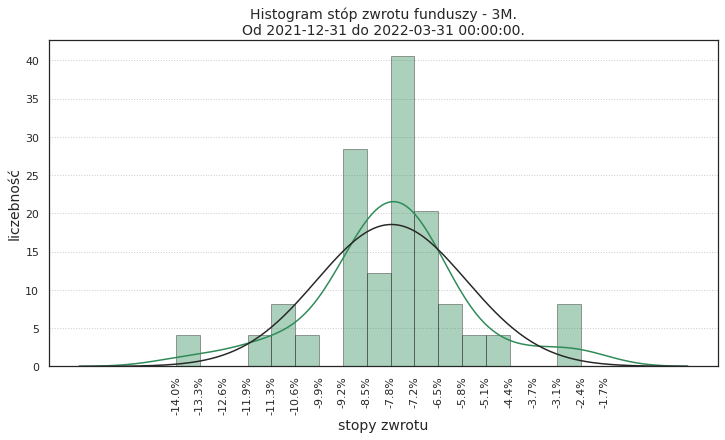

In [486]:
### histogram miesiecznych stop zwrotu dla wszystkich funduszy ###
pick_period = "3M"  #@param ['1M', '3M', '6M', '1Y', '3Y']
period = pick_period
# period = "1M"

funds_rates = []
for f in funds.columns:
    # print("f:", f)
    funds_rates.append(rate_of_return(rating_date, period, f, funds))


# print(funds_rates)
# plt.hist(funds_rates, bins=np.linspace(min(funds_rates), max(funds_rates), 15))

baskets = np.linspace(int(100*min(funds_rates)-1)/100, int(100*max(funds_rates)+1)/100, 20)
hist_param = {'linewidth':1, 'edgecolor':'k', 'density':True}
sns.distplot(funds_rates, bins=baskets, hist=True, fit=norm, kde=True, color='seagreen', hist_kws=hist_param, norm_hist=True)#, kde_kws={"cut":0})

plt.title("Histogram stóp zwrotu funduszy - {}.\nOd {} do {}.".format(period, period_to_date(rating_date, period), rating_date), fontdict={'size':14})
plt.xlabel("stopy zwrotu", fontdict={'size':14})
plt.xticks(rotation=90)
plt.ylabel("liczebność", fontdict={'size':14})
plt.yticks(rotation=0)

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
ax.xaxis.set_ticks(baskets[:-1])
ax.grid(axis='y', linestyle='dotted', linewidth=1)

fig = plt.gcf()
fig.set_size_inches(12, 6)


plt.show()

In [487]:
### table with rates of return ###
periods = ["1M", "3M", "6M", "1Y", "3Y"]

def get_rates(funds, start_date, periods):
    rates = pd.DataFrame()
    for f in funds.columns:
        fund_rates = []
        for p in periods:
            fund_rates.append(rate_of_return(start_date, p, f, funds))
        rates[f] = fund_rates
    # print(fund_rates)

    rates.index = periods
    rates.columns = funds.columns
    return rates

# print(rates)
rates = get_rates(funds, rating_date, periods)
# display(rates.columns)
rates 


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.061551,0.036550,0.042050,0.060702,0.078015,0.087598,NaN,0.034456,0.056781,0.055706,...,0.056240,0.060565,0.107397,0.058660,0.066628,0.031556,0.055894,0.049404,0.072221,0.037098
3M,-0.099633,-0.135893,-0.075758,-0.073410,-0.086677,-0.088782,-0.066709,-0.091282,-0.069400,-0.024983,...,-0.112536,-0.078099,-0.044372,-0.082370,-0.068222,-0.119352,-0.065565,-0.077844,-0.066032,-0.064504
6M,-0.112014,-0.131127,-0.076834,-0.076530,-0.119918,-0.093352,-0.076465,-0.037086,-0.086410,0.018811,...,-0.133229,-0.082049,-0.066532,-0.082879,-0.078505,-0.105175,-0.061204,NaN,-0.080258,-0.049341
1Y,0.074288,0.037308,0.149275,0.107045,0.023731,0.054665,0.115288,0.080239,0.099000,0.200322,...,0.012373,0.111001,0.098002,0.094981,0.115700,0.042727,0.096241,NaN,0.082012,0.031021
3Y,0.707052,0.375364,0.302135,0.268144,0.295897,0.298178,0.283902,0.495474,0.180139,0.194080,...,-0.035796,-0.004941,-0.283934,-0.010073,-0.056012,0.211246,0.203167,NaN,NaN,0.148383


In [488]:
print(type(start_date))
print(type(bench_cum_rates.index[0]))
print(bench_cum_rates.index, start_date, periods)
print(start_date in bench_cum_rates.index)
bench_rates_periods = get_rates(bench_cum_rates, rating_date, periods)
bench_rates_periods

<class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
DatetimeIndex(['2018-01-03', '2018-01-04', '2018-01-05', '2018-01-08',
               '2018-01-09', '2018-01-10', '2018-01-11', '2018-01-12',
               '2018-01-15', '2018-01-16',
               ...
               '2022-04-07', '2022-04-08', '2022-04-11', '2022-04-12',
               '2022-04-13', '2022-04-14', '2022-04-19', '2022-04-20',
               '2022-04-21', '2022-04-22'],
              dtype='datetime64[ns]', name='Data', length=1075, freq=None) 2022-04-23 00:00:00 ['1M', '3M', '6M', '1Y', '3Y']
False


,WIG,SWIG80,MWIG40,TBSP,"0,6WIG+0,4sWIG",WIBOR
1M,0.061481,0.080237,0.041090,-0.041882,0.069582,0.023518
3M,-0.073878,-0.031914,-0.112330,-0.046892,-0.056315,0.052997
6M,-0.077345,-0.066025,-0.090899,-0.120858,-0.071555,0.076630
1Y,0.117402,0.062505,0.095722,-0.133793,0.097163,0.083388
3Y,0.075541,0.639722,0.142661,-0.055455,0.281329,0.232245


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

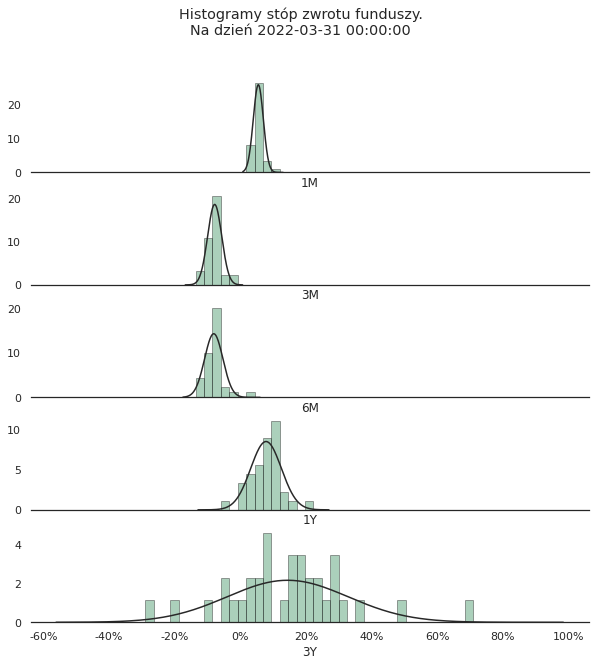

In [489]:
### plot all histograms ###

global_min = rates.min().min()
global_max = rates.max().max()
baskets = np.linspace(int(100*global_min-1)/100, int(100*global_max+1)/100, 40)
hist_param = {'linewidth':1, 'edgecolor':'k', 'density':True}
kde_param = {"shade": True}

sns.set(style="white", palette="muted", color_codes=True)

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)
sns.despine(left=True)

kde_show = False

for i,p in enumerate(periods):
    sns.distplot(rates.loc[p], bins=baskets, hist=True, fit=norm, kde=kde_show, color='seagreen', hist_kws=hist_param, kde_kws=kde_param, ax=axes[i])

plt.suptitle("Histogramy stóp zwrotu funduszy.\nNa dzień {}".format(rating_date, fontdict={'size':14}))

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
# ax.xaxis.set_ticks(baskets[:-1:5])
# ax.grid(axis='x', linestyle='dotted', linewidth=2, color="#AAAAAA")

plt.show()

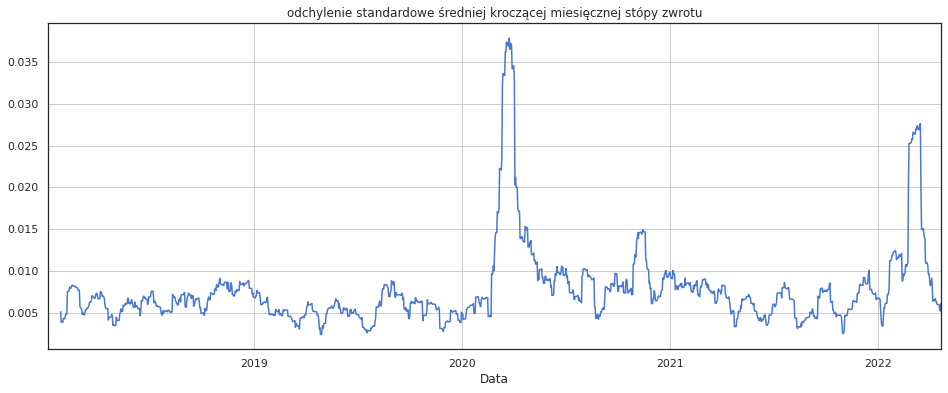

In [490]:
### standard deviation - pandemic efect ###
### std for every day, for 21 funds ###

# funds_rev = funds.reindex(index=funds.index[::-1])

# # funds.iloc[::-1]
# # funds_rev = funds
# std_seriesh = funds_rev.pct_change(periods=1, fill_method='pad')
# std_seriesh = std_seriesh.std(axis=1)
# # print(std_seriesh)
# # plt.plot(std_series)
# std_seriesh.plot(figsize=(16, 6), title='odchylenie standardowe stóp zwrotu\nrozrzut pomiędzy funduszami dla wybranej grupy', grid=True)
# # fig = plt.gcf()

###########################
### for moving 22 days  ###
std_seriesv = funds.pct_change(periods=1, fill_method='pad')

std_seriesv = std_seriesv.mean(axis=1)
std_seriesv = std_seriesv.rolling(22).std()

# print(pd.isna(std_seriesv.iloc[0, -1]))
# # std_seriesv.plot(figsize=(12, 8), title='odchylenie standardowe średniej kroczącej miesięcznej stópy zwrotu', legend=False, grid=True)
std_seriesv.plot(figsize=(16, 6), title='odchylenie standardowe średniej kroczącej miesięcznej stópy zwrotu', legend=False, grid=True)
# display(std_seriesv)


In [491]:
display(std_seriesv)

Data
2018-01-03         NaN
2018-01-04         NaN
2018-01-05         NaN
2018-01-06         NaN
2018-01-07         NaN
                ...   
2022-04-18    0.005974
2022-04-19    0.005974
2022-04-20    0.005301
2022-04-21    0.005210
2022-04-22    0.006112
Length: 1571, dtype: float64

In [492]:
### table with standard deviation ###

# I own you (and also myself) explaination:
# 1. reverse DataFrame, it loose the newest days otherwise
# 2. take df and calculate percent change
# 3. rafactor pct change into ln change
# 4. calculate 23 days (one calendar month) std
# 5. annualize items by mult by sqrt(250)
# 6. and we get full DataFrame of monthly std in two lines of code! (could be one line easly...)

def get_std_dt(funds, period):
    p = {"1M":23, "3M":66, "6M":130, "1Y":250, "3Y":750}
    funds_rev = funds.reindex(index=funds.index[::-1])
    pstd = funds_rev.pct_change().apply(lambda x: np.log(1+x)).rolling(p[period]).std().apply(lambda x: x*np.sqrt(250))
    return pstd

# after I've done all above I realized only this 5th periods is needed...
# so I packed thouse two lines above into function and added dic for periods
# lets try again

periods = ["1M", "3M", "6M", "1Y", "3Y"] # create dictionary with period beginning days, calculations are repeted

# start_date = pd.Timestamp(year=2021, month=12, day=31)

def std_div(start_date, period, funds):
    ''' 
    get standard diviation for specific period for all funds
    attributes:
    start_date - date of analisis, type: datatime
    period - element of ["1M", "3M", "6M", "1Y", "3Y"], type: string
    funds - funds DataFrame

    output: standard deviation of daily log rate of return, annualised, type: pd.Series
    '''
    dat = period_to_date(start_date, period)
    # print(dat, type(dat))
    dat = find_date(dat, funds)
    # print(dat, type(dat))
    funds_rev = funds.reindex(index=funds.index[::-1])
    filt = funds_rev.index >= dat
    funds_rev = funds_rev[filt]
    # print(funds_rev)

    pstd = funds_rev.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
    return pstd

def get_std(start_date, periods, funds):
    '''
    create std dev DateFrame for all funds and periods
    '''
    std = pd.DataFrame()
    for p in periods:
        std[p] = std_div(start_date, p, funds)
    std = std.T # std.transpose()
    return std

# print(type(std_div(start_date, "1Y", funds)))
# std_div(start_date, "1Y", funds)
funds_std_periods = get_std(rating_date, periods, funds)
funds_std_periods
# get_std_dt(funds, "1M")


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.176376,0.174153,0.196654,0.202872,0.198996,0.210225,0.075249,0.208984,0.191812,0.188327,...,0.220159,0.231353,0.231074,0.228911,0.238619,0.216360,0.171725,0.222932,0.207797,0.147283
3M,0.238834,0.246659,0.250424,0.263157,0.241198,0.288558,0.128846,0.209618,0.265387,0.226876,...,0.295309,0.301546,0.338219,0.300699,0.300000,0.261482,0.238719,0.250276,0.261748,0.201435
6M,0.188589,0.195634,0.200230,0.210073,0.189432,0.228000,0.123241,0.168836,0.212281,0.185905,...,0.235692,0.241335,0.264883,0.240456,0.246369,0.207831,0.189990,0.191296,0.209109,0.162623
1Y,0.149152,0.155629,0.166034,0.167879,0.151810,0.179103,0.114795,0.136984,0.169050,0.155247,...,0.186765,0.194186,0.206174,0.190720,0.200210,0.163486,0.150969,0.138831,0.165692,0.129126
3Y,0.157662,0.162355,0.164290,0.172566,0.171062,0.179691,0.157204,0.162207,0.177334,0.161378,...,0.199589,0.198378,0.220036,0.185904,0.201328,0.162560,0.164645,0.081656,0.120476,0.154175


In [493]:
### Sharpe - piece of cake ###
### liczę Sharpa do odchylenia std z Rf, było do std funduszu ###
sharpe = rates.sub(bench_rates_periods["0,6WIG+0,4sWIG"], axis='index')
sharpe_periods = sharpe.div(funds_std_periods)
sharpe_periods



,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,-0.045531,-0.189674,-0.140003,-0.043769,0.042377,0.085700,NaN,-0.168079,-0.066735,-0.073681,...,-0.060601,-0.038977,0.163649,-0.047711,-0.012380,-0.175756,-0.079711,-0.090513,0.012701,-0.220554
3M,-0.181373,-0.322623,-0.077640,-0.064962,-0.125883,-0.112514,-0.080676,-0.166816,-0.049308,0.138102,...,-0.190381,-0.072243,0.035309,-0.086650,-0.039692,-0.241078,-0.038750,-0.086023,-0.037125,-0.040652
6M,-0.214535,-0.304510,-0.026363,-0.023684,-0.255304,-0.095603,-0.039845,0.204159,-0.069978,0.486087,...,-0.261673,-0.043485,0.018963,-0.047094,-0.028211,-0.161766,0.054482,NaN,-0.041619,0.136600
1Y,-0.153363,-0.384598,0.313866,0.058866,-0.483710,-0.237281,0.157893,-0.123547,0.010870,0.664487,...,-0.453991,0.071261,0.004070,-0.011441,0.092589,-0.332970,-0.006107,NaN,-0.091437,-0.512224
3Y,2.700221,0.579188,0.126637,-0.076411,0.085160,0.093764,0.016365,1.320189,-0.570621,-0.540651,...,-1.588887,-1.443057,-2.568956,-1.567484,-1.675584,-0.431120,-0.474730,NaN,NaN,-0.862311


In [494]:
### Tracking error (from benchmark), std of difference fund rates and benchmark rate ###

### funds rates of return ###
funds_rates = funds[::-1].pct_change(1)[::-1]
# funds_rates

rates_diff = funds_rates.sub(bench_rates['TBSP'], axis='index')
rates_diff

def tr_std_div(start_date, period, rates_diff):
    ''' 
    get standard diviation for ....
    attributes:
    start_date - date of analisis, type: datatime
    period - element of ["1M", "3M", "6M", "1Y", "3Y"], type: string
    funds - funds DataFrame

    output: standard deviation of daily log rate of return, annualised, type: pd.Series
    '''
    dat = period_to_date(start_date, period)
    # print(dat, type(dat))
    dat = find_date(dat, rates_diff)
    # print(dat, type(dat))
    diff_rev = rates_diff.reindex(index=rates_diff.index[::-1])
    filt = diff_rev.index >= dat
    diff_rev = diff_rev[filt]
    # print(funds_rev)

    tr_std = diff_rev.apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
    return tr_std

def get_tr_std(start_date, periods, rates_diff):
    '''
    create std dev DateFrame for all funds and periods
    '''
    std = pd.DataFrame()
    for p in periods:
        std[p] = tr_std_div(start_date, p, rates_diff)
    std = std.T # std.transpose()
    return std


tracking_err = get_tr_std(rating_date, periods, rates_diff)
tracking_err
# rates_diff


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.236287,0.230472,0.254439,0.262413,0.258691,0.270497,0.138856,0.268770,0.251526,0.242218,...,0.280178,0.290429,0.319670,0.288597,0.296825,0.270585,0.226483,0.278559,0.269258,0.194024
3M,0.293813,0.301522,0.306918,0.322295,0.296094,0.352024,0.167804,0.257854,0.325479,0.277924,...,0.358893,0.366700,0.420773,0.365967,0.364459,0.316779,0.292851,0.304214,0.320339,0.245689
6M,0.232474,0.239923,0.244879,0.256318,0.232786,0.278181,0.156117,0.208866,0.259712,0.226750,...,0.285798,0.292702,0.327557,0.291885,0.298441,0.251821,0.233009,0.233794,0.255350,0.198174
1Y,0.185420,0.192237,0.204163,0.206359,0.188193,0.219684,0.146029,0.171179,0.207830,0.191122,...,0.228189,0.237060,0.254303,0.233006,0.244159,0.199952,0.186549,0.170268,0.203129,0.158866
3Y,0.194963,0.200124,0.201362,0.212148,0.211033,0.220488,0.194484,0.202287,0.217934,0.198626,...,0.244319,0.242359,0.269454,0.227455,0.245553,0.199829,0.202782,0.102839,0.148197,0.189179


In [495]:
### Tracking error (from funds avg), std of difference fund rates and avg funds rate ###

### funds rates of return ###
# already exist !
# funds_rates = funds[::-1].pct_change(1)[::-1]  
# funds_rates

funds_avg_return = funds_rates.mean(axis='columns')
funds_avg_return

rates_diff = funds_rates.sub(funds_avg_return, axis='index')
rates_diff

avg_tracking_err = get_tr_std(rating_date, periods, rates_diff)
avg_tracking_err



,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.066549,0.046546,0.039257,0.033759,0.061114,0.060016,0.164265,0.072466,0.022462,0.057319,...,0.055681,0.064758,0.210615,0.059662,0.125132,0.061452,0.018008,0.064946,0.046514,0.085638
3M,0.053459,0.052173,0.036774,0.031930,0.054185,0.071943,0.219621,0.106620,0.031874,0.063148,...,0.065295,0.071144,0.199626,0.069150,0.108421,0.051353,0.019029,0.048907,0.041748,0.082871
6M,0.048503,0.048015,0.037563,0.028351,0.055373,0.060975,0.163215,0.089462,0.027135,0.053313,...,0.055366,0.058808,0.159833,0.056929,0.101379,0.042600,0.016416,0.057391,0.038417,0.071536
1Y,0.044524,0.047293,0.037651,0.025417,0.050548,0.053254,0.119362,0.072526,0.031167,0.047273,...,0.045959,0.049549,0.130832,0.045470,0.083902,0.043247,0.015649,0.075123,0.038224,0.061560
3Y,0.058079,0.054357,0.050247,0.030893,0.055053,0.053712,0.075113,0.087224,0.034032,0.049106,...,0.071348,0.051865,0.149745,0.041553,0.115642,0.042351,0.022732,0.140494,0.120405,0.060199


In [496]:
### Information ratio, rates diff / tracking error ###
### use avg rates of return of all funds ###

### moved upwards, needed for tracking error ###
# funds_avg_return = rates.mean(axis='columns')
# funds_avg_return

funds_avg_return_perionds = rates.mean(axis='columns')
funds_avg_return_perionds

ir_avg_periods = rates.sub(funds_avg_return_perionds, axis='index')
ir_avg_periods = ir_avg_periods.div(avg_tracking_err)
ir_avg_periods


,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.099731,-0.394552,-0.327700,0.171453,0.377991,0.544587,NaN,-0.282316,0.083122,0.013811,...,0.023808,0.087251,0.249188,0.062788,0.093610,-0.380114,0.054375,-0.084849,0.372078,-0.208042
3M,-0.401760,-1.106649,0.065198,0.148612,-0.157283,-0.147706,0.052116,-0.123121,0.274671,0.842030,...,-0.526549,0.000786,0.169230,-0.060957,0.091615,-0.802241,0.661620,0.006356,0.290387,0.164734
6M,-0.640058,-1.044634,0.110101,0.156565,-0.703378,-0.203085,0.027594,0.490527,-0.200512,1.871611,...,-0.943894,-0.018369,0.090328,-0.033548,0.024305,-0.568217,1.204051,NaN,0.018518,0.442135
1Y,-0.093636,-0.870090,1.880916,1.124730,-1.082669,-0.446771,0.308561,0.024562,0.659120,2.577874,...,-1.437898,0.656790,0.149386,0.363385,0.443879,-0.826196,1.136413,NaN,0.093003,-0.770572
3Y,9.692086,4.253617,3.144196,4.013619,2.756378,2.867664,1.860580,4.027853,1.057527,1.016809,...,-2.522053,-2.874574,-2.858751,-3.711436,-1.730872,1.584320,2.596302,NaN,NaN,0.070332


In [497]:
### Information ratio, rates diff / tracking error ###
### use benchmark rates of return ###


ir_bench_periods = rates.sub(bench_rates_periods['TBSP'], axis='index')
ir_bench_periods = ir_bench_periods.div(tracking_err)
ir_bench_periods

,QUERCUS Parasolowy SFIO Subfundusz Agresywny,Pekao Subfundusz Pekao Akcji Aktywna Selekcja FIO,MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,Credit Agricole FIO Subfundusz Akcyjny,Allianz FIO Subfundusz Selektywny,AGIO Subfundusz Akcji Plus,UNIQA FIO Subfundusz Selektywny Akcji Polskich,Investor FIO Subfundusz Akcji Spółek Dywidendowych,Santander Prestiż SFIO Subfundusz Akcji Polskich,Rockbridge FIO Parasolowy Subfundusz Akcji,...,Skarbiec FIO Subfundusz Akcji Skarbiec Akcja,PKO Akcji Rynku Polskiego,Novo FIO Subfundusz Novo Akcji,inPZU Akcje Polskie O,Beta ETF WIG20TR,NN Parasol FIO Subfundusz Polski Odpowiedzialnego Inwestowania,BNP Paribas Akcji,VIG C-QUADRAT Akcji,PZU Akcji Polskich (PZU FIO Parasolowy),Faranklin zdywersyfikowany akcji
1M,0.437745,0.340309,0.329871,0.390928,0.463475,0.478675,NaN,0.284028,0.392260,0.402893,...,0.350213,0.352743,0.466979,0.348383,0.365569,0.271403,0.431713,0.327707,0.423769,0.407064
3M,-0.179504,-0.295171,-0.094050,-0.082278,-0.134367,-0.118996,-0.118098,-0.172153,-0.069154,0.078833,...,-0.182907,-0.085103,0.005988,-0.096944,-0.058525,-0.228741,-0.063763,-0.101745,-0.059750,-0.071682
6M,0.038043,-0.042804,0.179779,0.172939,0.004039,0.098876,0.284353,0.401082,0.132638,0.615959,...,-0.043287,0.132587,0.165851,0.130115,0.141913,0.062277,0.256015,NaN,0.158997,0.360881
1Y,1.122215,0.890049,1.386484,1.167085,0.837033,0.857856,1.705690,1.250339,1.120112,1.748173,...,0.640547,1.032624,0.911490,0.981834,1.021847,0.882809,1.233102,NaN,1.062404,1.037438
3Y,3.911029,2.152760,1.775858,1.525348,1.664914,1.603870,1.744908,2.723502,1.081032,1.256312,...,0.080468,0.208427,-0.847931,0.199524,-0.002268,1.334653,1.275377,NaN,NaN,1.077488


In [498]:
### finally create ranking ###
# print(rates)
# rates_rank = rates.drop(['1M', '3M', '6M', '3Y'])
rates_rank = rates.loc["1Y", :]
rates_rank = rates_rank.rank(axis=0, pct=True)
rates_rank = rates_rank.apply(lambda x: '{0:.0f}'.format(10*x))
rates_rank.T
r = pd.DataFrame()
r["stopa zwrotu 1Y"] = rates_rank.T

rates_rank = rates.loc["3Y", :]
rates_rank = rates_rank.rank(axis=0, pct=True)
rates_rank = rates_rank.apply(lambda x: '{0:.0f}'.format(10*x))
rates_rank.T
r["stopa zwrotu 3Y"] = rates_rank.T

std_rank = funds_std_periods.loc["1Y", :]
std_rank = std_rank.rank(axis=0, pct=True)
std_rank = std_rank.apply(lambda x: '{0:.0f}'.format(10*(1-x))) 
std_rank.T
r["odchylenie standardowe 1Y"] = std_rank.T

std_rank = funds_std_periods.loc["3Y", :]
std_rank = std_rank.rank(axis=0, pct=True)
std_rank = std_rank.apply(lambda x: '{0:.0f}'.format(10*(1-x))) # wywali err jeśłi będzie nan
std_rank.T
r["odchylenie standardowe 3Y"] = std_rank.T

sharpe_rank = sharpe_periods.loc["1Y", :]
sharpe_rank = sharpe_rank.rank(axis=0, pct=True)
sharpe_rank = sharpe_rank.apply(lambda x: '{0:.0f}'.format(10*x))
sharpe_rank.T
r["wskaźnik Sharpe'a 1Y"] = sharpe_rank.T

sharpe_rank = sharpe_periods.loc["3Y", :]
sharpe_rank = sharpe_rank.rank(axis=0, pct=True)
sharpe_rank = sharpe_rank.apply(lambda x: '{0:.0f}'.format(10*x))
sharpe_rank.T
r["wskaźnik Sharpe'a 3Y"] = sharpe_rank.T

ir_avg_rank = ir_avg_periods.loc["1Y", :]
ir_avg_rank = ir_avg_rank.rank(axis=0, pct=True)
ir_avg_rank = ir_avg_rank.apply(lambda x: '{0:.0f}'.format(10*x))
ir_avg_rank.T
r["Information Ratio (śr. fund.) 1Y"] = ir_avg_rank.T

ir_avg_rank = ir_avg_periods.loc["3Y", :]
ir_avg_rank = ir_avg_rank.rank(axis=0, pct=True)
ir_avg_rank = ir_avg_rank.apply(lambda x: '{0:.0f}'.format(10*x))
ir_avg_rank.T
r["Information Ratio (śr. fund.) 3Y"] = ir_avg_rank.T

### punkty rankingowe ###
# rnak_1Y = 
# print(type(r.iloc[7,1]))
# print(len(r.index))
# print(r.columns)
# print(r)

### wywalam nan dla 1Y (PKO-Akcji-Rynku-Polskiego-(Parasolowy-FIO), mBank Subfundusz Akcji Polskich ) ###
### uzupełnić ###

# print(r.iloc[len(r.index)-1, 1] == 'nan')
# print(r.columns[0])

filt = r['stopa zwrotu 1Y'] != 'nan'
# print(filt)
r = r[filt]
# print(r)

rank_1Y = [sum(int(r.iloc[i, j]) for j in range(0,len(r.columns),2))/4 for i in range(len(r.index))]

# print(rank_1Y)
# print(len(rank_1Y))

rank_3Y = [sum(int(r.iloc[i, j-1]) if r.iloc[i, j]=='nan' else int(r.iloc[i, j]) for j in range(1,len(r.columns),2))/4 for i in range(len(r.index))]
# print(rank_3Y)
# print(len(rank_3Y))

r['Ranking 1Y'] = rank_1Y
r['Ranking 3Y'] = rank_3Y
# print(r['Ranking 1Y'] + r['Ranking 3Y'])
r['SUMA'] = r['Ranking 1Y'] + r['Ranking 3Y']
r.sort_values(by='SUMA', ascending=False, inplace=True)

r.to_csv(f"/content/drive/My Drive/FundPicking/FY2021/{rating_file}")
r


,stopa zwrotu 1Y,stopa zwrotu 3Y,odchylenie standardowe 1Y,odchylenie standardowe 3Y,wskaźnik Sharpe'a 1Y,wskaźnik Sharpe'a 3Y,Information Ratio (śr. fund.) 1Y,Information Ratio (śr. fund.) 3Y,Ranking 1Y,Ranking 3Y,SUMA
MetLife SFIO Parasol Światowy Subfundusz Akcji Polskich,10,9,5,6,10,9,10,9,8.75,8.25,17.00
UNIQA FIO Subfundusz Selektywny Akcji Polskich,9,8,9,8,9,8,6,8,8.25,8.00,16.25
Rockbridge FIO Parasolowy Subfundusz Akcji,10,6,6,7,10,6,10,6,9.00,6.25,15.25
Credit Agricole FIO Subfundusz Akcyjny,8,8,4,4,8,8,9,9,7.25,7.25,14.50
BNP Paribas Akcji,7,7,7,6,7,7,9,8,7.50,7.00,14.50
Investor FIO Subfundusz Akcji Spółek Dywidendowych,5,10,8,7,4,10,5,9,5.50,9.00,14.50
QUERCUS Parasolowy SFIO Subfundusz Agresywny,4,10,7,8,4,10,4,10,4.75,9.50,14.25
MetLife FIO Akcji,9,8,2,2,9,8,9,7,7.25,6.25,13.50
BPS FIO Subfundusz BPS Akcji,8,4,9,6,9,4,8,4,8.50,4.50,13.00
Noble Funds FIO Subfundusz Akcji Polskich,9,7,1,2,9,7,9,7,7.00,5.75,12.75
